In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas
 

In [ ]:
!pip install scikit-learn

In [2]:
import os

# Define o nível de log do TensorFlow para 3 (erro)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importa o módulo de log do TensorFlow e define o nível de log para erro
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


stderr = os.dup(2) # Cria uma cópia do descritor de arquivo 2 (stderr)
os.close(2) # Fecha o descritor de arquivo 2

os.open(os.devnull, os.O_RDWR) # Abre o descritor de arquivo 2 e o redireciona para /dev/null


import tensorflow as tf
tf.get_logger().setLevel('ERROR')
print(tf.config.list_physical_devices('GPU'))


# os.dup2(stderr, 2) # Restaura o stderr original

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Configurações
BATCH_SIZE = 16
EPOCHS = 100
IMAGE_SIZE = 64
MAIN_DIR = '_recortado'
CHANNELS = 31

In [5]:
import string 

# Função para remover números de uma string
def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [6]:
folder_to_label = {}
id_to_label = {}

# Carrega as pastas
folders = sorted(os.listdir(MAIN_DIR))

# Nos temos um conjunto de categorias, cada categoria possui 5 amostras
# Entao uma categoria tem 5 pastas. Exemplo (ardidos1, ardidos2, ardidos3, ardidos4 e ardidos5)
# Removemos o numero no do final do nome da pasta e adicionamos ao dicionario

i = -1
for folder in folders:
    # Pega o nome da pasta remove o numero e adiciona ao dicionario
    # O nome da pasta eh o label 
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))

    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i


# Cria um dicionario que mapeia o id para o label
for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

# print(folder_to_label)

print("Categorias:")
for key, values in id_to_label.items():
    print(f'\t{key}: {values}')

    
 

Categorias:
	0: ardidos
	1: bandinhas
	2: chochos
	3: fermentados
	4: imaturos
	5: mofados
	6: purpuras
	7: queimados
	8: soja
	9: soja_b


In [7]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string
import random

# Funcao para carregar todas imagens de um grao de uma amostra e empilhar elas retornando um array
def load_multispectral_imagem(sample_dir):
    # Pega o diretorio de uma amostra
    file_names = sorted(os.listdir(sample_dir))
    # Quantidade de graos é a quantidade de imagens dividido por 31
    qtd_graos = int(len(file_names)/CHANNELS)
    #print(f'Quantidade de graos: {qtd_graos}\n')

    multispectral_imgs = []

    # Para cada grao carrega as 31 imagens e empilha elas em um array
    for i in range(qtd_graos):
        # Os arquivos tem formato label_{id_grao}_{id_canal}.png
        # Ou seja, para cada grao existem 31 imagens, uma para cada canal
        images = [np.array(Image.open(os.path.join(sample_dir, file))) for file in file_names[i*31:(i+1)*31]]

        # Empilha as imagens em um array
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)  
   
    # Exibe o resultado da aleatorizacao
    
    # fig, axs = plt.subplots(1,2, figsize=(10,5))
    # imagem1 = multispectral_imgs[0][:,:,0]
    # axs[0].imshow(imagem1, cmap='gray')
    # axs[0].axis('off')
    random.shuffle(multispectral_imgs)
    # imagem2 = multispectral_imgs[0][:,:,0]
    # axs[1].imshow(imagem2, cmap='gray')
    # axs[1].axis('off')
    # plt.show()

    return multispectral_imgs, qtd_graos

In [8]:
# Função para carregar as imagens
def process_path(sample_dir, label):
    # Carrega as imagens
    images, qtd_graos = load_multispectral_imagem(sample_dir)
    # Cria um array de labels
    labels = [label]*len(images)
    # Retorna as imagens e os labels em um dataset do tensorflow
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Converte as imagens para uint8 e os labels para int32
    # uint8 é um tipo de dado que armazena inteiros de 0 a 255
    # int32 é um tipo de dado que armazena inteiros de -2^31 a 2^31-1
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int8)))

    # Separa o dataset em batches
    dataset = dataset.batch(BATCH_SIZE)
    return dataset, qtd_graos

In [9]:
def create_count_dict():
    qtd_por_categoria = {}
    for key, value in id_to_label.items():
        qtd_por_categoria[value] = 0
    return qtd_por_categoria


In [10]:
# Função para criar o dataset
def create_dataset(base_dir, folder_to_label):
    qtd_por_categoria = create_count_dict()
    
    # Lista para armazenar os datasets de treino, validação e teste
    train_datasets = []
    val_datasets = []
    test_datasets = []

    for folder_name, label in folder_to_label.items():
        categoria = id_to_label[label] 
        
        print(f'Processando a amostra {folder_name}')
        sample_dir = os.path.join(base_dir, folder_name)
        dataset, qtd_graos = process_path(sample_dir, label)
        
        qtd_por_categoria[categoria] += qtd_graos

        train_size = int(0.8 * len(dataset))
        test_size = int(0.1 * len(dataset))
        val_size = len(dataset) - train_size - test_size
        
        print(train_size, val_size, test_size)

        train_dataset = dataset.take(train_size)
        val_dataset = dataset.skip(train_size).take(val_size)
        test_dataset = dataset.skip(train_size + val_size).take(test_size)

        train_datasets.append(train_dataset)
        val_datasets.append(val_dataset)
        test_datasets.append(test_dataset)

    # Concatena todos os datasets com dados de treino, validação e teste
    combined_train_dataset = train_datasets[0]
    for ds in train_datasets[1:]:
        combined_train_dataset = combined_train_dataset.concatenate(ds)

    combined_val_dataset = val_datasets[0]
    for ds in val_datasets[1:]:
        combined_val_dataset = combined_val_dataset.concatenate(ds)

    combined_test_dataset = test_datasets[0]
    for ds in test_datasets[1:]:
        combined_test_dataset = combined_test_dataset.concatenate(ds)

    return combined_train_dataset, combined_val_dataset, combined_test_dataset, qtd_por_categoria


# Chama a função para criar o dataset
train_dataset_original, val_dataset_original, test_dataset_original, qtd_por_categoria  = create_dataset(MAIN_DIR, folder_to_label=folder_to_label)

Processando a amostra ardidos1
10 2 1
Processando a amostra ardidos2
8 1 1
Processando a amostra ardidos3
8 2 1
Processando a amostra ardidos4
8 2 1
Processando a amostra ardidos5
8 1 1
Processando a amostra bandinhas1
8 1 1
Processando a amostra bandinhas2
8 1 1
Processando a amostra bandinhas3
8 1 1
Processando a amostra bandinhas4
8 1 1
Processando a amostra bandinhas5
11 2 1
Processando a amostra chochos1
4 2 0
Processando a amostra chochos2
6 2 0
Processando a amostra chochos3
4 2 0
Processando a amostra chochos4
5 2 0
Processando a amostra chochos5
7 2 0
Processando a amostra fermentados1
4 2 0
Processando a amostra fermentados2
5 2 0
Processando a amostra fermentados3
6 2 0
Processando a amostra fermentados4
7 2 0
Processando a amostra fermentados5
6 2 0
Processando a amostra imaturos1
3 1 0
Processando a amostra imaturos2
3 1 0
Processando a amostra imaturos3
3 1 0
Processando a amostra imaturos4
3 1 0
Processando a amostra imaturos5
3 1 0
Processando a amostra mofados1
3 1 0
P

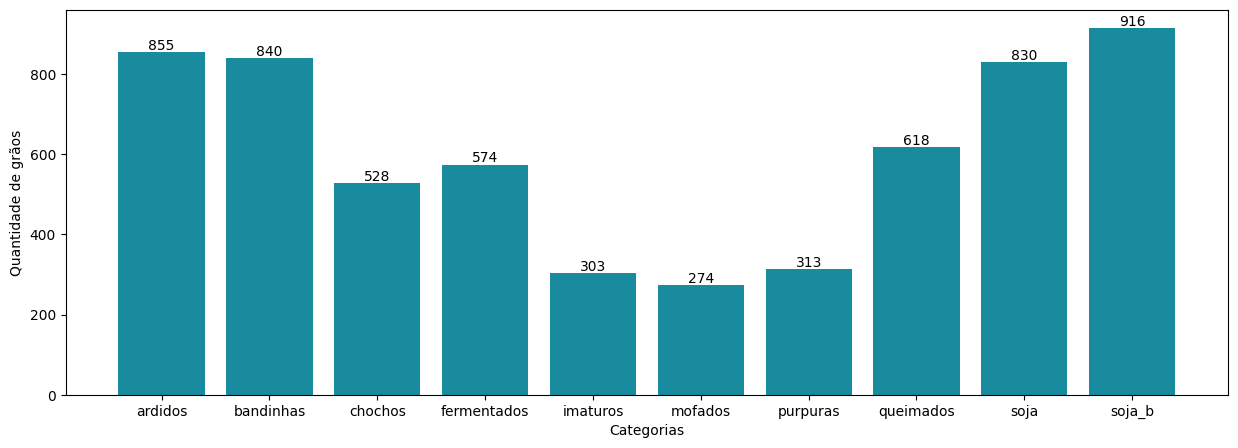

In [11]:
plt.figure(figsize=(15, 5))
labels = qtd_por_categoria.keys()
qtds = qtd_por_categoria.values()
bars = plt.bar(qtd_por_categoria.keys(), qtd_por_categoria.values(), color='#188c9e')

plt.xlabel('Categorias')
plt.ylabel('Quantidade de grãos')

for bar, qtd in zip(bars, qtds):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.5, str(qtd),
             ha='center', va='bottom', color='black', fontsize=10)

plt.show()

In [14]:
print(f''' 
Dataset de treino: {len(train_dataset_original)}
Dataset de validação: {len(val_dataset_original)}
Dataset de teste: {len(test_dataset_original)}
''')

 
Dataset de treino: 300
Dataset de validação: 81
Dataset de teste: 16



In [15]:
from sklearn.decomposition import PCA


# Funcao para aplicar o PCA em um conjunto de imagens
def apply_pca(train_images, n_components=10):
    # Redimensionar imagens para 2D para aplicar PCA
    # O reshape basicamente aplana as imagens 4D em 2D
    # O train_images chega com a forma (número de imagens, largura, altura, canais) 32x64x64x31
    flat_train_images = train_images.reshape(-1, train_images.shape[-1])
    pca = PCA(n_components=n_components)

    # Fit ajusta o modelo PCA aos dados de treinamento
    # Durante o ajuste, o PCA calcula os componentes principais dos dados
    # Transform transforma os dados de treinamento em componentes principais
    transformed_train_images = pca.fit_transform(flat_train_images)

    # Redimensionar de volta para a forma original com os componentes principais
    # Sera retornado um array 4D de 32x64x64x10
    transformed_train_images = transformed_train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], n_components)
    return pca, transformed_train_images

In [16]:
def transform_pca(pca, images):
    flat_images = images.reshape(-1, images.shape[-1])
    transformed_images = pca.transform(flat_images)
    transformed_images = transformed_images.reshape(images.shape[0], images.shape[1], images.shape[2], -1)
    return transformed_images

In [17]:

# Função para aplicar o PCA em um conjunto de imagens
def preprocess_dataset(ds, pca=None, fit_pca=False):
    images_list = []
    labels_list = []

    # Transforma o dataset em uma lista de imagens e labels
    for images, labels in ds:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    # Empilha as imagens e labels
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Aplica PCA nas imagens
    # Se fit_pca for True, o PCA será ajustado aos dados de treinamento
    # Se pca for fornecido, ele será aplicado às imagens
    if fit_pca:
        pca, images = apply_pca(images, n_components=10)
    elif pca is not None:
        images = transform_pca(pca, images)

    # Transforma as imagens e labels em um dataset do TensorFlow com batches de tamanho BATCH_SIZE
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)
    return dataset, pca


In [18]:
train_dataset, pca = preprocess_dataset(train_dataset_original, fit_pca=True)
val_dataset, _ = preprocess_dataset(val_dataset_original, pca=pca)
test_dataset, _ = preprocess_dataset(test_dataset_original, pca=pca)



In [42]:
def compare_pca_image(original, transformed, num_channels=5):
    # Figura 2 linhas e num_channels de colunas
    fig, axs = plt.subplots(2,num_channels, figsize=(10,5))

    # Para cada canal exibe a imagem transformada (pca) e a original
    for i in range(num_channels):
        img_original = original[...,i]
        axs[0,i].imshow(img_original, cmap='gray')
        axs[0,i].axis('off')
        img_transformed = transformed[...,i]
        axs[1,i].imshow(img_transformed, cmap='gray')
        axs[1,i].axis('off')

    

    
    fig.text(0.5, 0.95, 'Original', ha='center', va='center', fontsize=14)  
    fig.text(0.5, 0.48, 'Transformed', ha='center', va='center', fontsize=14)

    plt.tight_layout() # Ajusta o layout para evitar sobreposição de titulos
    plt.show()

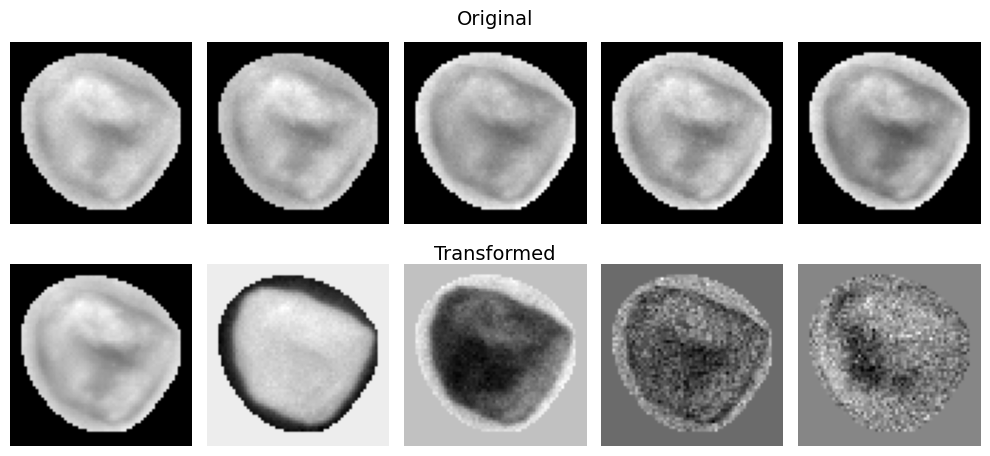

In [44]:
transformed_dataset = train_dataset.take(1)
original_dataset = train_dataset_original.take(1)

transformed_batch_iter = transformed_dataset.as_numpy_iterator()
original_batch_iter = original_dataset.as_numpy_iterator()

transformed_first_batch = next(transformed_batch_iter)
original_first_batch = next(original_batch_iter)

transformed_images, _ = transformed_first_batch
original_images, _ = original_first_batch

# for i in range(len(transformed_images)):
compare_pca_image(original_images[i], transformed_images[i])

In [45]:
# Cache, Shuffle e Prefetch
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
# funcao que mostra todos batch de imagens do dataset
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [47]:
# Funcao para separar o dataset em treino, validacao e teste e embaralhar
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [48]:
# altera o tamanho da imagem e normaliza os valores
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# aumenta a quantidade de imagens no dataset atraves de flip e rotacao
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


10


In [49]:
# visualizacao dos tensores
for data, label in train_dataset.take(10):
    print(data.shape, label)

(16, 64, 64, 10) tf.Tensor([6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8], shape=(16,), dtype=int8)
(16, 64, 64, 10) tf.Tensor([8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8], shape=(16,), dtype=int8)


In [50]:
LAYER_SIZE = 10 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, LAYER_SIZE)

# Cria o modelo de rede neural convolucional
# Aplicando camadas de convolução, pooling e densas
# Densas são camadas totalmente conectadas
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


# Compila o modelo aplicando a função de otimização, função de perda e métricas
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2965 - loss: 2.1140 - val_accuracy: 0.5514 - val_loss: 1.2896
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5653 - loss: 1.2030 - val_accuracy: 0.5670 - val_loss: 1.0647
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6067 - loss: 1.0411 - val_accuracy: 0.5936 - val_loss: 0.9683
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6748 - loss: 0.8498 - val_accuracy: 0.6872 - val_loss: 0.7902
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7429 - loss: 0.7238 - val_accuracy: 0.7633 - val_loss: 0.7244
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7603 - loss: 0.6264 - val_accuracy: 0.7881 - val_loss: 0.5518
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8074 - loss: 0.5310 - val_accuracy: 0.7661 - val_loss: 0.6117
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8018 - loss: 0.5656 - val_accuracy: 0.8073 - val_

In [54]:
model.evaluate(test_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.1667


[0.10737093538045883, 0.9751552939414978]

Text(0.5, 1.0, 'training and validation accuracy')

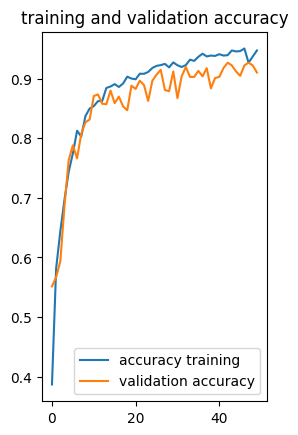

In [55]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='accuracy training')
plt.plot(range(50), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

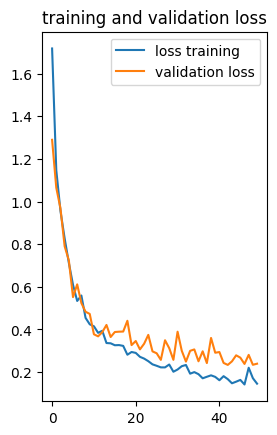

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(50), loss, label='loss training')
plt.plot(range(50), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


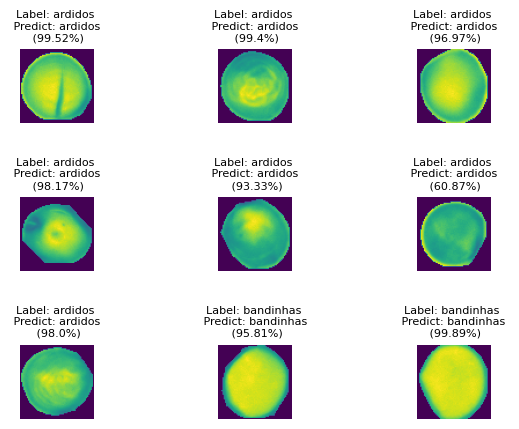

In [63]:
test_dataset = test_dataset.shuffle(buffer_size=10)
for images_batch, labels_batch in test_dataset.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [51]:
model.save(f"models/model_new{n_classes}_64.keras")